In [1]:
import numpy as np
from numpy.linalg import norm
from math import *
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import random
from scipy.spatial import ConvexHull
from matplotlib.animation import FuncAnimation
from matplotlib import path
import time
import cv2
from glob import glob
import os
import shutil
from queue import PriorityQueue 
from queue import LifoQueue
%matplotlib inline

In [2]:
#https://stackoverflow.com/questions/10944621/dynamically-updating-plot-in-matplotlib

In [3]:
def draw_map(obstacles):
    world_bounds_x = [-2.5, 2.5]
    world_bounds_y = [-2.5, 2.5]


    # Draw obstacles
    fig = plt.figure(figsize=(10, 10))
    plt.grid()
    ax = plt.gca()
    ax.set_xlim(world_bounds_x)
    ax.set_ylim(world_bounds_y)
    for k in range(len(obstacles)):
        ax.add_patch(Polygon(obstacles[k]))

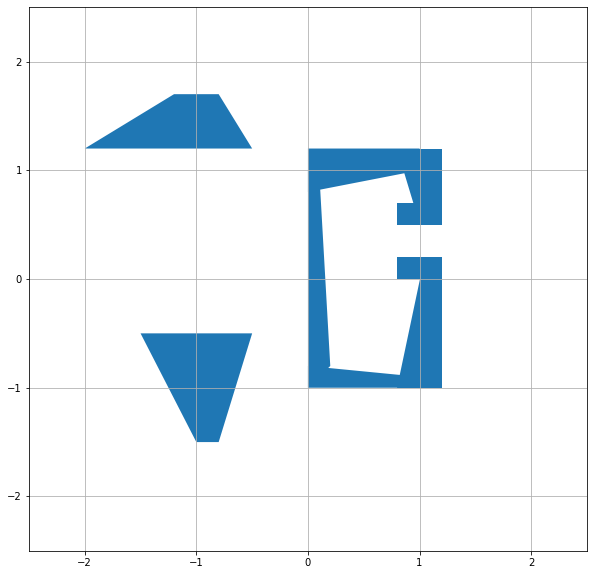

In [4]:
w = 0.2
#Creating arbritarily shaped obstacles
obstacles = [
              np.array([[0, -1], [1, -1], [1, -0.9], [0, w-1]]),
              np.array([[0, -1], [w, -0.8], [0.1, 1], [0.0, 1.0]]),
              np.array([[0, 1-w], [1, 1], [1, 1+w], [0, 1+w]]),
              np.array([[1-w, -1], [1+w, -1], [1+w, 0], [1, 0]]),
              np.array([[1-w, 1+w], [1+w, 1+w], [1+w, 0.5], [1, 0.5]]),
              np.array([[0.8, 0], [1+w, 0], [1+w, w], [0.8, w]]),
              np.array([[0.8, 0.5], [1+w, 0.5], [1+w, 0.5+w], [0.8, 0.5+w]]),

              np.array([[-0.5, -0.5], [-1.5, -0.5], [-1, -1.5], [-0.8, -1.5]]),

              np.array([[-0.5, 1.2], [-2.0, 1.2], [-1-w, 1.5+w], [-0.8, 1.5+w]])
            ]
draw_map(obstacles)

In [5]:
class Node:
    def __init__(self):
        self.p     = [0, 0]
        self.i     = 0
        self.iPrev = 0

In [6]:
def closestNode(rrt, p):
    #Finds the closest node in the tree to the generated point.
    distance = []
    for node in rrt:
        distance.append( sqrt((p[0] - node.p[0]) ** 2 + (p[1] - node.p[1]) ** 2) )
    distance = np.array(distance)

    dmin = min(distance)
    ind_min = distance.tolist().index(dmin)
    closest_node = rrt[ind_min]

    return closest_node

In [7]:
def isCollisionFreeVertex(obstacles, xy):
    #Checking if the point has spawned in a valid location
    collFree = True

    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
            return collFree

    return collFree

In [8]:
def isCollisionFreeEdge(obstacles, closest_vert, xy):
    #Checking if the line joining closest_vert and xy is free of obstacles or not
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    collFree = True
    l = norm(closest_vert - xy)
    map_resolution = 0.01; M = int(l / map_resolution)
    if M <= 2: M = 20
    t = np.linspace(0, 1, M)
    for i in range(1 ,M-1):
        p = (1 - t[i]) * closest_vert + t[i] * xy
        collFree = isCollisionFreeVertex(obstacles, p) 
        if collFree == False: return False

    return collFree

In [9]:
def start_node(source):
    #Creates the source of class Node
    start_node = Node()
    start_node.p = source
    start_node.i = 0
    start_node.iPrev = 0 
    return start_node

In [10]:
def get_point(goal):
    #Generates a random point in the grid space
#     rnd = random.random()
#     if rnd < 0.01:
#         #For good convergence, generating a point close to the goal
#         point = np.array([goal[0] + rnd, goal[0] + rnd])
#     elif rnd >= 0.01 and rnd < 0.02:
#         point = np.array([goal[0] + rnd, goal[0] - rnd]) 
#     elif rnd >= 0.02 and rnd < 0.03:
#         point = np.array([goal[0] - rnd, goal[0] - rnd]) 
#     elif rnd >= 0.03 and rnd < 0.04:
#         point = np.array([goal[0] - rnd, goal[0] + rnd]) 
#     else:
    point = np.array([random.random() * 5 - 2.5, random.random() * 5 - 2.5])    
    return point

In [11]:
def get_closest_node(tree, point, d = 0.2):
    #Get's a 
    closest_node = closestNode(tree, point)
    new_node = Node()
    new_node.p = closest_node.p + d * (point - closest_node.p)
    new_node.i = len(tree)
    new_node.iPrev = closest_node.i
    return new_node

In [12]:
def get_points_non_holo(exploree, V, dt):
    #Generates a random point in the grid space
    dalpha = np.arange(-15,16,1)
    random.shuffle(dalpha)
    alpha_arr = np.array(dalpha[0:5])
    points = []
    for angle in alpha_arr:
        Vx = np.array(cos(radians(angle)) * V)
        Vy = np.array(sin(radians(angle)) * V)
        points.append(np.array([exploree[0] + Vx * dt, exploree[1] + Vy * dt]))
    points = np.asarray(points)
    return points

In [30]:
def closest_node_stack(input_stack, goal):
    minD = 10e4
    #need to modify to 
    stack = LifoQueue()
    closest = np.array([666999, 999666])
    #print(input_stack.qsize())
    for ele in range(input_stack.qsize()):
        head = input_stack.get()
        dist = head[0]
        pp   = head[1]
        if dist < minD:
            if minD == 10e4:
                pass
            else:
                stack.put((minD, closest))
            minD = dist
            closest = pp
        else:
            stack.put((dist, pp))
    return stack, closest

In [31]:
def frames_to_video(input_path, output_path, fps):
    '''
        Function to Concatenate given frames and fps into a video file.
        Input Arguments
        input_path  : Path to the input directory containing input frames
        output_path : Path to the output directory containing the video file
        fps         : Frames per Second of the output video
        Return
        Boolean     : True is Video written successfully, False if writing is not successful.
    '''

    image_files = sorted(glob(input_path))
    final = len(image_files)
    #for i in range(20):
    #    image_files.append(image_files[final - 1])
        
    frames = [] 
    for f in image_files: 
        frame = cv2.imread(f)
        height, width, channels = frame.shape
        size = (width, height)
        frames.append(frame)

    video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    return True
#frames_to_video("./plots_temp/*.png", "./capture_temp.mp4", 24)

1
[0.78523135 0.23180518]
2
[0.78634761 0.24028402]
3
[0.78880638 0.26581933]
4
[0.78992537 0.29144832]
5
[0.77929232 0.40187673]
6
[1.27248117 0.20636071]
7
[1.275154   0.20610335]
8
[1.27567609 0.2146394 ]
9
[1.27612211 0.21460038]
10
[1.27627298 0.23173234]
11
[1.27634761 0.24028402]
12
[1.27455983 0.2574498 ]
13
[1.275154   0.27446469]
14
[1.27157897 0.29152116]
15
[1.27985074 0.28289664]
16
[1.275154   0.32553531]
17
[1.26563994 0.34216075]
18
[1.27873176 0.32562899]
19
[1.27136218 0.35090693]
20
[1.26742773 0.35917041]
21
[1.26425129 0.38436106]
22
[1.26921769 0.39332505]
23
[1.26660805 0.45309568]
24
[1.26563994 0.46159271]
25
[1.26452368 0.47007155]
26
[1.26028964 0.49537314]
27
[1.74578482 0.07953938]
28
[1.75156702 0.09605865]
29
[1.75311742 0.10441339]
30
[1.74786348 0.13062847]
31
[1.75644846 0.12970783]
32
[1.75823189 0.1295518 ]
33
[1.74845765 0.14764336]
34
[1.75563994 0.13840729]
35
[1.75734493 0.14678761]
36
[1.75890341 0.15519641]
37
[1.76024027 0.15507945]
38
[1.7612

[2.25485387 0.24022937]
301
[2.25530296 0.24027621]
302
[2.25121292 0.24909307]
303
[2.24257629 0.26558561]
304
[2.23821152 0.27434757]
305
[2.24725505 0.2574498 ]
306
[2.23894294 0.27502527]
307
[2.2395326  0.27405954]
308
[2.2485962  0.25740297]
309
[2.24889578 0.2570726 ]
310
[2.2535898  0.24890593]
311
[2.25388575 0.2488357 ]
312
[2.25418398 0.24884872]
313
[2.25418398 0.24884872]
314
[2.24087129 0.27396593]
315
[2.25023591 0.2571896 ]
316
[2.25478087 0.24881226]
317
[2.23224799 0.29150297]
318
[2.25098906 0.25764214]
319
[2.2474843  0.26550732]
320
[2.23873431 0.28193876]
321
[2.23872889 0.28240606]
322
[2.24763789 0.26600385]
323
[2.25246973 0.2573223 ]
324
[2.22090903 0.31733286]
325
[2.25336321 0.25726765]
326
[2.25366189 0.25738478]
327
[2.25500474 0.25736134]
328
[2.23321611 0.3       ]
329
[2.24347685 0.28235368]
330
[2.24800638 0.27404337]
331
[2.23459121 0.29900137]
332
[2.24346324 0.28282143]
333
[2.23488262 0.29891053]
334
[2.23439521 0.29981325]
335
[2.25269468 0.265985

[2.24084179 0.486631  ]
600
[2.23613556 0.49509328]
601
[2.23656045 0.49537314]
602
[2.21829035 0.52882726]
603
[2.24348882 0.48707396]
604
[2.22942888 0.51210275]
605
[2.24014039 0.49537314]
606
[2.2402656  0.49571052]
607
[2.23574078 0.50388577]
608
[2.22625932 0.52020103]
609
[2.23347222 0.51190894]
610
[2.24415055 0.49572398]
611
[2.2346626  0.51186678]
612
[2.24140444 0.50404983]
613
[2.23700212 0.51249964]
614
[2.22296233 0.53740433]
615
[2.24377752 0.50426785]
616
[2.24377534 0.50429902]
617
[2.23458797 0.52041846]
618
[2.24437169 0.50432506]
619
[2.23018836 0.52893109]
620
[2.24014037 0.5125079 ]
621
[2.2209659  0.54572005]
622
[2.23121667 0.52911241]
623
[2.22922025 0.53742812]
624
[2.23203844 0.53764348]
625
[2.24303157 0.52135297]
626
[2.23399107 0.5375114 ]
627
[2.23633876 0.53798836]
628
[2.24191292 0.52986036]
629
[2.23960723 0.53824559]
630
[2.23132773 0.55432705]
631
[2.22386995 0.57120855]
632
[2.23395844 0.55492527]
633
[2.2405728  0.54688828]
634
[2.24146546 0.546958

AttributeError: 'numpy.ndarray' object has no attribute 'p'

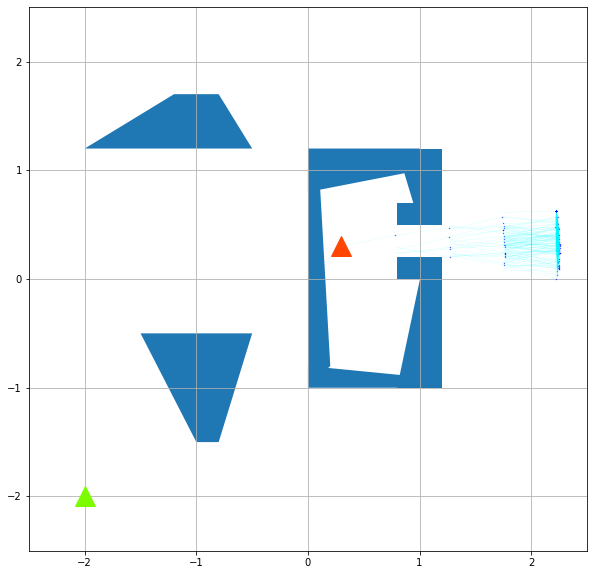

In [43]:
if __name__ == "__main__":
    maxiters  = 1000
    nearGoal = False 
    minDistGoal = 0.08 
    d = 0.7
    dt = 0.7
    if os.path.isdir("./plots_temp"):
        shutil.rmtree("./plots_temp")
    os.mkdir("./plots_temp")
    
    draw_map(obstacles)
    stack = LifoQueue()
    xy_start = np.array([0.3, 0.3]); plt.plot(xy_start[0],xy_start[1],'^',color = 'orangered', markersize = 20)
    xy_goal =  np.array([-2.0, -2.0]);  plt.plot(xy_goal[0], xy_goal[1], '^',color = 'lawngreen',markersize = 20)

    rrt = []
    rrt.append(start_node(xy_start))

    #pq = PriorityQueue()
    start_time = time.time()
    iters = 0
    to_explore = Node()
    to_explore.p = xy_start
    to_explore.i = 0
    to_explore.iPrev = 0
    while not nearGoal and iters < maxiters:
        iters += 1
        print(iters)
        sampled_trajectories = get_points_non_holo(to_explore.p, d, dt)
        for t in sampled_trajectories:
            if isCollisionFreeEdge(obstacles, to_explore.p, t) and t[0] < 2.5 and t[0] > -2.5 and t[1] < 2.5 and t[1] > -2.5:
                dist_from_goal = norm(xy_goal - t)
                to_node = Node()
                to_node.p = t
                to_node.iPrev = to_explore.i
                to_node.i = to_explore.i + 1
                #try:
                stack.put(((float(dist_from_goal), to_node)))
                    #https://stackoverflow.com/questions/40205223/priority-queue-with-tuples-and-dicts
                #except:
                #    pass
                rrt.append(to_node)

        plt.plot(to_node.p[0], to_node.p[1], 'o',color = 'blue', markersize = 0.3)
        plt.plot([to_explore.p[0], to_node.p[0]], [to_explore.p[1], to_node.p[1]], color = 'aqua', linewidth = 0.07)
        #try:
        stack, obj = closest_node_stack(stack, xy_goal)
        to_explore = obj
        print(obj.p)
        #plt.savefig("./plots_temp/" + str(iters) + ".png")

        #If the current node is closer to the goal than other nodes
#         if norm(np.array(xy_goal) - np.array(new_node.p)) < minDistGoal:
#             goal_node = Node()
#             goal_node.p = xy_goal
#             goal_node.i = len(rrt)
#             goal_node.iPrev = new_node.i
#             if isCollisionFreeEdge(obstacles, new_node.p, goal_node.p):
#                 rrt.append(goal_node)
#                 P = [goal_node.p]
#             else: P = []
#             end_time = time.time()
#             nearGoal = True
#             print('Reached the goal after %.2f seconds:' % (end_time - start_time))


    plt.title("RRT path", fontsize = 20, color = 'green')
    i = len(rrt) - 1

    try:
        while True:
            i = rrt[i].iPrev
            P.append(rrt[i].p)
            if i == 0:
                break
        P = np.array(P)
        print('Number of iterations taken: ',iters)
        print('Number of nodes: ', len(rrt))
        print(f"Number of nodes on the RRT path: {P.shape[0]}")
        plt.plot( P[:,0], P[:,1], color = 'gold', linewidth = 5 )
    except:
        print(f"The Rapid Exploring Random Tree algorithm wasn't able to converge in {maxiters} iterations")
    finally:
        pass
        #frames_to_video("./plots_temp/*.png", "./capture.mp4", 24)


In [15]:
#alpha = random.randint(0,360)
#alpha = float(alpha)
#print(alpha)

In [16]:

#get_points_non_holo(np.array([1,1]), 0.1,0.1)